In [1]:
#数据处理
import numpy as np
import pandas as pd
#数据可视化
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# 使用r2_score 作为回归模型性能的评价
from sklearn.metrics import r2_score
#显示中文
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family'] = ['sans-serif']
#解决-变成方框问题
matplotlib.rcParams['axes.unicode_minus'] = False

In [3]:
#读取数据
dpath = "./Data/Test1/"
df = pd.read_csv(dpath + "FE_Advertising.csv")
#通过观察前5 行，了解数据每列（特征）的概况
df.head()

,TV,radio,newspaper,sales
0,0.969852,0.981522,1.778945,22.1
1,-1.197376,1.082808,0.669579,10.4
2,-1.516155,1.528463,1.783549,9.3
3,0.052050,1.217855,1.286405,18.5
4,0.394182,-0.841614,1.281802,12.9


In [4]:
# 数据总体信息
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [5]:
# 从原始数据中分离输入特征x 和输出y
y = df['sales']
X = df.drop('sales', axis = 1)
#特征名称，用于后续显示权重系数对应的特征
feat_names = X.columns

In [6]:
#将数据分割训练数据与测试数据
from sklearn.model_selection import train_test_split
# 随机采样20%的数据构建测试样本，其余作为训练样本
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=33, test_size=0.2)
#X_train.shape

In [7]:
# 1、最小二乘线性回归
from sklearn.linear_model import LinearRegression
# 1.使用默认配置初始化学习器实例
lr = LinearRegression()
# 2.用训练数据训练模型参数
lr.fit(X_train, y_train)
# 3. 用训练好的模型对测试集进行预测
y_test_pred_lr = lr.predict(X_test)
y_train_pred_lr = lr.predict(X_train)
#性能评估，R 方分数
print("The r2 score of LinearRegression on test is %f" %(r2_score(y_test, y_test_pred_lr)))
print("The r2 score of LinearRegression on train is %f" %(r2_score(y_train, y_train_pred_lr)))
# 看看各特征的权重系数，系数的绝对值大小可视为该特征的重要性
fs = pd.DataFrame({"columns":list(feat_names), "coef":list((lr.coef_.T))})
#lr.coef_.T 权重 lr.intercept_ 截距
#fs.sort_values(by=['coef'],ascending=False)
fs = fs.append([{'columns':'intercept','coef':lr.intercept_}], ignore_index=True)
fs

The r2 score of LinearRegression on test is 0.893729
The r2 score of LinearRegression on train is 0.896285


,columns,coef
0,TV,3.983944
1,radio,2.860230
2,newspaper,0.038194
3,intercept,13.969091


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, '残差')

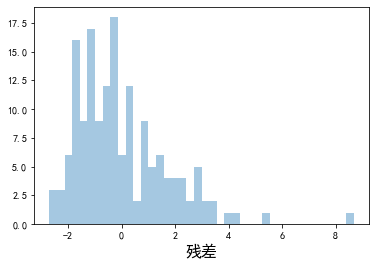

In [8]:
#在训练集上观察预测残差的分布，看是否符合模型假设：噪声为0 均值的高斯噪声
figsize = 11,9 # 设置输出的图片大小
res = y_train_pred_lr - y_train
sns.distplot(res, bins=40, kde = False)
plt.xlabel(u'残差', fontsize = 16)

Text(0, 0.5, '残差')

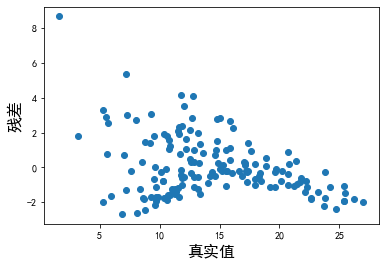

In [9]:
figsize = 11,9
plt.scatter(y_train, res)
plt.xlabel(u'真实值', fontsize = 16)
plt.ylabel(u'残差', fontsize = 16)

The r2 score of Ridge on test is 0.893865
The r2 score of Ridge on train is 0.896285


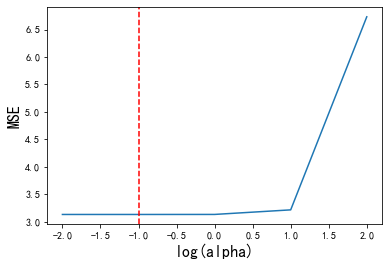

alpha is: 0.1


In [10]:
#2、岭回归
from sklearn.linear_model import RidgeCV
#1. 设置超参数（正则参数）范围
alphas = [ 0.01, 0.1, 1, 10, 100]
#2. 生成一个RidgeCV 实例
ridge = RidgeCV(alphas=alphas, store_cv_values=True)
#3. 模型训练
ridge.fit(X_train, y_train)
#4. 预测
y_test_pred_ridge = ridge.predict(X_test)
y_train_pred_ridge = ridge.predict(X_train)
#模型性能评估
print("The r2 score of Ridge on test is %f" %(r2_score(y_test, y_test_pred_ridge)))
print("The r2 score of Ridge on train is %f" %(r2_score(y_train, y_train_pred_ridge)))
# 看看各特征的权重系数，系数的绝对值大小可视为该特征的重要性
fs = pd.DataFrame({"columns":list(feat_names), "coef":list((ridge.coef_.T))})
#fs.sort_values(by=['coef'],ascending=False)
fs = fs.append([{'columns':'intercept','coef':ridge.intercept_}], ignore_index=True)
fs

mse_mean = np.mean(ridge.cv_values_, axis = 0)
plt.plot(np.log10(alphas), mse_mean.reshape(len(alphas),1))
#最佳超参数
plt.axvline(np.log10(ridge.alpha_), color='r', ls='--')
plt.xlabel('log(alpha)', fontsize = 16)
plt.ylabel('MSE', fontsize = 16)
plt.show()
print ('alpha is:', ridge.alpha_)


In [11]:
#3、Lasso回归
from sklearn.linear_model import LassoCV
#1. 设置超参数搜索范围
#Lasso 可以自动确定最大的alpha，所以另一种设置alpha 的方式是设置最小的alpha 值（eps） 和 超参数的数目（n_alphas），
#然后LassoCV 对最小值和最大值之间在log 域上均匀取值n_alphas 个
# np.logspace(np.log10(alpha_max * eps), np.log10(alpha_max),num=n_alphas)[::-1]
#2 生成LassoCV 实例（默认超参数搜索范围）
lasso = LassoCV()
#3. 训练（内含CV）
lasso.fit(X_train, y_train)
#4. 测试
y_test_pred_lasso = lasso.predict(X_test)
y_train_pred_lasso = lasso.predict(X_train)
# 评估，使用r2_score 评价模型在测试集和训练集上的性能
print("The r2 score of lasso on test is %f" %(r2_score(y_test, y_test_pred_lasso)))
print("The r2 score of lasso on train is %f" %(r2_score(y_train, y_train_pred_lasso)))
# 看看各特征的权重系数，系数的绝对值大小可视为该特征的重要性
fs = pd.DataFrame({"columns":list(feat_names), "coef_lr":list((lr.coef_.T)), "coef_ridge":list((ridge.coef_.T)), "coef_lasso":list((lasso.coef_.T))})
#fs.sort_values(by=['coef_lr'],ascending=False)
fs = fs.append([{'columns':'intercept','coef_lr':lr.intercept_, 'coef_ridge':ridge.intercept_, 'coef_lasso':lasso.intercept_}], ignore_index=True)
fs

The r2 score of lasso on test is 0.896497
The r2 score of lasso on train is 0.896201


,columns,coef_lr,coef_ridge,coef_lasso
0,TV,3.983944,3.981524,3.955278
1,radio,2.860230,2.858304,2.836651
2,newspaper,0.038194,0.038925,0.015882
3,intercept,13.969091,13.969282,13.970449


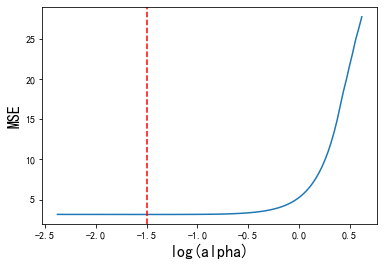

alpha is: 0.031532988198277837


In [12]:
mses = np.mean(lasso.mse_path_, axis = 1)
plt.plot(np.log10(lasso.alphas_), mses)
#最佳超参数
plt.axvline(np.log10(lasso.alpha_), color='r', ls='--')
plt.xlabel('log(alpha)', fontsize = 16)
plt.ylabel('MSE', fontsize = 16)
plt.show()
print ('alpha is:', lasso.alpha_)

In [13]:
#4、弹性网络回归
from sklearn.linear_model import ElasticNetCV
#1. 设置超参数搜索范围
#Lasso 可以自动确定最大的alpha，所以另一种设置alpha 的方式是设置最小的alpha 值（eps） 和 超参数的数目（n_alphas），
#然后LassoCV 对最小值和最大值之间在log 域上均匀取值n_alphas 个
# np.logspace(np.log10(alpha_max * eps), np.log10(alpha_max),num=n_alphas)[::-1]
l1_ratio = [0.01, 0.1, .5, .7, .9, .95, .99, 1]
#2 ElasticNetCV（设置超参数搜索范围）
elastic_net = ElasticNetCV(l1_ratio = l1_ratio )
#3. 训练（内含CV）
elastic_net.fit(X_train, y_train)
#4. 测试
y_test_pred_elastic_net = elastic_net.predict(X_test)
y_train_pred_elastic_net = elastic_net.predict(X_train)
# 评估，使用r2_score 评价模型在测试集和训练集上的性能
print("The r2 score of elastic_net on test is %f" %(r2_score(y_test, y_test_pred_elastic_net)))
print("The r2 score of elastic_net on train is %f" %(r2_score(y_train, y_train_pred_elastic_net)))
# 看看各特征的权重系数，系数的绝对值大小可视为该特征的重要性
fs = pd.DataFrame({"columns":list(feat_names), "coef_lr":list((lr.coef_.T)), "coef_ridge":list((ridge.coef_.T)), "coef_lasso":list((lasso.coef_.T)), 'coef_elastic_net':list((elastic_net.coef_.T))})
#fs.sort_values(by=['coef_lr'],ascending=False)
fs = fs.append([{'columns':'intercept','coef_lr':lr.intercept_, 'coef_ridge':ridge.intercept_, 'coef_lasso':lasso.intercept_, 'coef_elastic_net':elastic_net.intercept_}], ignore_index=True)
fs

The r2 score of elastic_net on test is 0.896497
The r2 score of elastic_net on train is 0.896201


,columns,coef_lr,coef_ridge,coef_lasso,coef_elastic_net
0,TV,3.983944,3.981524,3.955278,3.955278
1,radio,2.860230,2.858304,2.836651,2.836651
2,newspaper,0.038194,0.038925,0.015882,0.015882
3,intercept,13.969091,13.969282,13.970449,13.970449


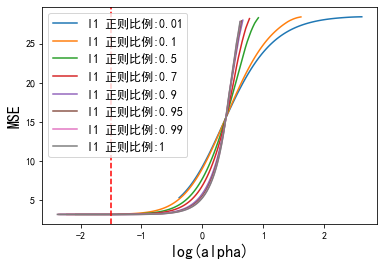

alpha is: 0.031532988198277837
l1_ratio is: 1.0


In [14]:
mses = np.mean(elastic_net.mse_path_, axis = 2)
# plot results
n_l1_ratio = len(l1_ratio)
n_alpha = elastic_net.alphas_.shape[1]
for i, l1 in enumerate(l1_ratio):
    plt.plot(np.log10(elastic_net.alphas_[i]), mses[i], label= u'l1 正则比例:'+str(l1))
#最佳超参数
plt.axvline(np.log10(elastic_net.alpha_), color='r', ls='--')
plt.xlabel('log(alpha)', fontsize = 16)
plt.ylabel('MSE', fontsize = 16)
plt.legend(fontsize = 12)
plt.show()
print ('alpha is:', elastic_net.alpha_)
print ('l1_ratio is:', elastic_net.l1_ratio_)

No handles with labels found to put in legend.


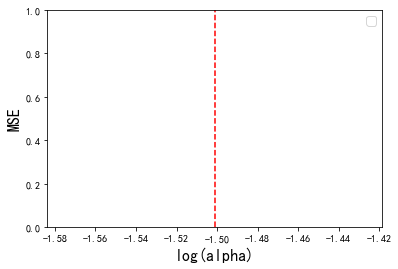

alpha is: 0.031532988198277837
l1_ratio is: 1.0


In [15]:
#最佳超参数
plt.axvline(np.log10(elastic_net.alpha_), color='r', ls='--')
plt.xlabel('log(alpha)', fontsize = 16)
plt.ylabel('MSE', fontsize = 16)
plt.legend(fontsize = 12)
plt.show()
print ('alpha is:', elastic_net.alpha_)
print ('l1_ratio is:', elastic_net.l1_ratio_)

In [16]:
# 5、Huber 回归
from sklearn.linear_model import HuberRegressor
# 1.使用默认配置初始化学习器实例
hr = HuberRegressor()
# 2.用训练数据训练模型参数
hr.fit(X_train, y_train)
# 3. 用训练好的模型对测试集进行预测
y_test_pred_hr = hr.predict(X_test)
y_train_pred_hr = hr.predict(X_train)
# 看看各特征的权重系数，系数的绝对值大小可视为该特征的重要性
fs = pd.DataFrame({"columns":list(feat_names), "coef":list((hr.coef_.T))})
#fs.sort_values(by=['coef'],ascending=False)
fs = fs.append([{'columns':'intercept','coef':hr.intercept_}], ignore_index=True)
fs

,columns,coef
0,TV,3.840762
1,radio,2.931079
2,newspaper,-0.023874
3,intercept,14.237015


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, '残差直方图')

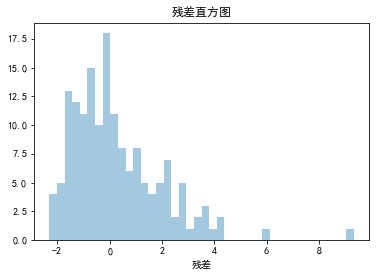

In [17]:
#在训练集上观察预测残差的分布，看是否符合模型假设：噪声为0 均值的高斯噪声
figsize = 11,9
res = y_train_pred_hr - y_train
sns.distplot(res, bins=40, kde = False)
plt.xlabel(u'残差')
plt.title(u'残差直方图')

Text(0, 0.5, '残差')

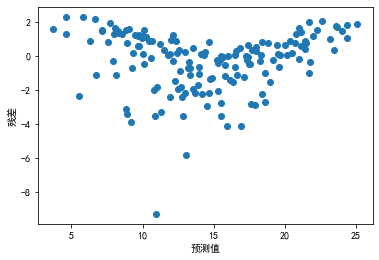

In [18]:
figsize = 11,9
res = y_train - y_train_pred_hr
plt.scatter(y_train_pred_hr, res)
plt.xlabel(u'预测值')
plt.ylabel(u'残差')